<a href="https://colab.research.google.com/github/jan-kreischer/UZH_ML4NLP/blob/main/Project-01/index_jan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 01 - Linear Classification




## Dependencies

In [2]:
!pip install demoji

     |████████████████████████████████| 42 kB 679 kB/s 


In [3]:
!pip install googletrans==4.0.0rc1

     |████████████████████████████████| 55 kB 2.3 MB/s 
     |████████████████████████████████| 42 kB 1.0 MB/s 
     |████████████████████████████████| 1.2 MB 27.7 MB/s 
     |████████████████████████████████| 65 kB 3.0 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17415 sha256=ab51c0e4dc37633575e4f28eb4253156e8a7e8ea46131278007b70852f53d617
  Stored in directory: /root/.cache/pip/wheels/43/34/00/4fe71786ea6d12314b29037620c36d857e5d104ac2748bf82a
Successfully built googletrans


## Imports

In [4]:
from googletrans import Translator
translator = Translator()

import csv
import re
import numpy as np

import pandas as pd
pd.set_option('display.max_rows', 200)  
pd.set_option('display.max_columns', 200)   
pd.set_option('display.width', 4000) 

from io import StringIO
import requests
import matplotlib.pyplot as plt

import demoji

from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


In [5]:
url_train_dev = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTOZ2rC82rhNsJduoyKYTsVeH6ukd7Bpxvxn_afOibn3R-eadZGXu82eCU9IRpl4CK_gefEGsYrA_oM/pub?gid=1863430984&single=true&output=tsv'
url_test = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-KNR9nuYatLkSbzSRgpz6Ku1n4TN4w6kKmFLkA6QJHTfQzmX0puBsLF7PAAQJQAxUpgruDd_RRgK7/pub?gid=417546901&single=true&output=tsv'

In [6]:
#translated_data = pd.read_pickle('sample_data/augmented_data.pkl')

## Constants

In [7]:
TARGET_COLUMN = 'label'
TWEET_COLUMN = 'tweet'
SAMPLE_THRESHOLD = 20

## 1. Data Acquisition

In [8]:
def load_dataset(url):
    r = requests.get(url)
    data = r.content.decode('utf8')
    df = pd.read_csv(StringIO(data), sep='\t')
    df.columns = ['tweet', 'label']
    return df

In [9]:
training_data = load_dataset(url_train_dev)
test_data = load_dataset(url_test)

In [10]:
dataset = pd.concat([training_data, test_data], axis=0) # Merge into one dataset for the pre-processing

In [11]:
print("The length of the combined dataset is {0} training samples + {1} test samples = {2} samples".format(len(training_data), len(test_data), len(dataset)))

The length of the combined dataset is 52675 training samples + 13279 test samples = 65954 samples


In [12]:
dataset = dataset.sample(frac=1).reset_index(drop=True) # Randomly shuffle the data

In [13]:
dataset.head(10)

,tweet,label
0,Anyone goin to the rope swing?,en
1,No fue fácil pero valió la pena.,es
2,@jochortega es plaga el lala jajajaja,es
3,特進の校舎のトイレはウォシュレットがついていて羨ましい,ja
4,"두 눈을 감은 이유가, 누구때문도 아니기를...",ko
5,"Today stats: One follower, No unfollowers via ...",en
6,Phone-hacking case shows openness is best poli...,en
7,@BlEBERSKING haha baby💕,und
8,Brezilya artik sana aciyorum. :(,tr
9,@EmmaPereyraaa jajajaja ;))))),und


## 2. Data Exploration

In [14]:
def data_exploration(df):
  n_labels = len(np.unique(df["label"]))
  df = df.sort_values('label')
  print("Dataset contains the columns: {}".format(list(df.keys())))
  print("with a total of {} observations".format(len(df)))
  print("and {} different possible labels.".format(n_labels))
  print("The unique labels are {}".format(df["label"].unique()))
  plt.figure(figsize=(15, 3))
  plt.hist(df["label"], bins=n_labels)
  plt.xticks(rotation=90)
  plt.yscale("log")
  plt.xlabel("Language")
  plt.ylabel("#Occurences")
  plt.show()

In [15]:
def get_underrepresented_languages(df, target_column, sample_threshold):
    df = df.groupby(target_column).size().to_frame().reset_index(drop=False).rename(columns={0: 'occurences'})
    underrepresented_languages = list(df[df['occurences'] < SAMPLE_THRESHOLD][target_column])
    return underrepresented_languages

In [16]:
def print_number_of_underrepresented_languages(df, target_column, sample_threshold):
  underrepresented_languages = get_underrepresented_languages(df, target_column, sample_threshold)
  print("There are {} languages in this data set with less then {} samples.".format(len(underrepresented_languages), sample_threshold))

Dataset contains the columns: ['tweet', 'label']
with a total of 65954 observations
and 78 different possible labels.
The unique labels are ['ar' 'ar_LATN' 'az' 'bg' 'bn' 'bs' 'ca' 'cs' 'cy' 'da' 'de' 'dv' 'el'
 'en' 'es' 'et' 'eu' 'fa' 'fi' 'fr' 'gl' 'ha' 'he' 'hi' 'hi-Latn' 'hr'
 'ht' 'hu' 'hy' 'id' 'is' 'it' 'ja' 'ja_LATN' 'jv' 'km' 'ko' 'ko_LATN'
 'la' 'lv' 'mk' 'mn' 'mr' 'ms' 'ne' 'nl' 'no' 'pl' 'ps' 'ps_LATN' 'pt'
 'ro' 'ru' 'si' 'sk' 'sl' 'sq' 'sr' 'su' 'sv' 'sw' 'ta' 'ta_LATN' 'th'
 'tl' 'tn' 'tr' 'uk' 'und' 'ur' 'ur_LATN' 'vi' 'wo' 'xh' 'yo' 'zh-CN'
 'zh-TW' 'zu']


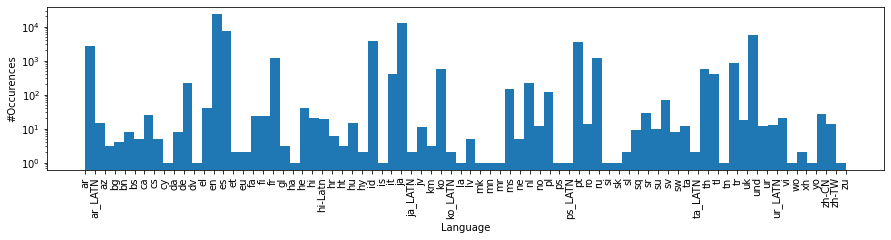

In [17]:
data_exploration(dataset)

In [18]:
print_number_of_underrepresented_languages(dataset, TARGET_COLUMN, SAMPLE_THRESHOLD)

There are 50 languages in this data set with less then 20 samples.


## 3. Text Cleaning

This is generally a good idea as many text classification tools rely on counting the occurrences of words. If both upper and lower case versions of the same word are found in the text then the algorithm will count them as different words even though the meaning is the same. Of course this does mean that where the capitalised versions of a word exists, that does have a different meaning. For example the company Apple vs the fruit apple. This could result in poorer performance for some data sets. This is one area of NLP where you may try different methods to see how they affect the overall performance of the model.

In [19]:
def remove_all_emojis(text):
  dem = demoji.findall(text)
  for item in dem.keys():
    text = text.replace(item, '')
  return text

In [20]:
def clean_data(df, column):
    df = df.copy(deep=True) # Make deep copy of tweets
    df[column] = df[column].str.lower() # Transform into all lowercase
    
    patterns = []
    retweet_pattern = '^RT'
    patterns.append(retweet_pattern)
    xml_pattern = '&\S+;'
    patterns.append(xml_pattern)
    hashtag_pattern = '#[A-Za-z0-9_]+'
    patterns.append(hashtag_pattern)
    twitter_mention_pattern = '@[A-Za-z0-9_]+'
    patterns.append(twitter_mention_pattern)
    http_pattern = 'http\S+'
    patterns.append(http_pattern)
    www_pattern = 'www\S+'
    patterns.append(www_pattern)
    tab_pattern = '\t'
    patterns.append(tab_pattern)
    punctuation_pattern = '[!"#$%&\\()*+,-./:;<=>?@\[\]^_`\'{}~]+'
    patterns.append(punctuation_pattern)
    numeric_pattern = '[0-9]+'
    patterns.append(numeric_pattern)
    regex = "|".join(patterns)

    #df[column] = df[column].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem)) 
    df[column] = df[column].apply(lambda elem: re.sub(r"{}".format(regex), "", elem))
    df[column] = df[column].apply(remove_all_emojis)
    
    return df

In [21]:
# Now we want to find out which special characters need to be removed from tweets in order to make the prediction better.
# We go over the printed list an not down the symbold which are not needed for language identification.
# These will be removed in a later step.
languages = list(np.unique(test_data['label']))
for language in languages:
  localized_tweets = training_data[training_data['label'] == language]
  # Clean and compare them
  cleaned_localized_tweets = clean_data(localized_tweets, 'tweet')
  comparison_view = pd.concat([localized_tweets.drop(['label'], axis=1), cleaned_localized_tweets], axis=1)
  print(comparison_view.head(5))
  #print(localized_tweets.head(5))
  print("---")

# Symbols like @<mention>, #, http://link !, numeric values (e.g 16000), " do not help for language identification.

                                               tweet                                              tweet label
0  يا من أناديها ويخنقني البكاء  ويكاد صمت الدمع ...  يا من أناديها ويخنقني البكاء  ويكاد صمت الدمع ...    ar
1  فيه فرق بين اهل غزة اللى مطحونين من ناحيتين وب...  فيه فرق بين اهل غزة اللى مطحونين من ناحيتين وب...    ar
2  ﻋﻦ ﺍﻟﻠﺤﻈﺔ اﻟﺤﻠﻮﺓﺓ ﺍﻟﻠﻲ ﺑﺘﻐﻤﺾ ﻓﻴﻬﺎ ﻋﻴﻨﻴﻚ ﺑﺘﻔﻜﺮ ...  ﻋﻦ ﺍﻟﻠﺤﻈﺔ اﻟﺤﻠﻮﺓﺓ ﺍﻟﻠﻲ ﺑﺘﻐﻤﺾ ﻓﻴﻬﺎ ﻋﻴﻨﻴﻚ ﺑﺘﻔﻜﺮ ...    ar
3                                  يا ابو سلو عرفتني                                  يا ابو سلو عرفتني    ar
4  ب50 ريال أكفل معتمر في رمضان ، ولك بإذن الله م...  ب ريال أكفل معتمر في رمضان ، ولك بإذن الله مثل...    ar
---
                                         tweet                            tweet    label
2199                      ya allah ya allah x)              ya allah ya allah x  ar_LATN
2200                   Ya rab tekhlas hel game          ya rab tekhlas hel game  ar_LATN
2201                           Istaqfurullah 😂                   ista

In [22]:
cleaned_dataset = clean_data(dataset, TARGET_COLUMN)

In [23]:
cleaned_dataset.isnull().values.any() # Dataset does not contain any rows with null values

False

# 4.Data Augmentation

In [35]:
def back_translation(df,target_languages=['en']):
  translated_data = pd.DataFrame(columns={TWEET_COLUMN, TARGET_COLUMN})
  for target_language in target_languages:
    for index, row in df.iterrows():
      try:
        tweet = row['tweet']
        source_language = row['label']
        translated_data=translated_data.append({'tweet': translator.translate(translator.translate(tweet, dest=target_language).text, dest=source_language).text, 'label': source_language}, ignore_index=True)
      except Exception as e:
        print(e)
        pass
  return translated_data

In [25]:
print_number_of_underrepresented_languages(cleaned_dataset, TARGET_COLUMN, SAMPLE_THRESHOLD)

There are 50 languages in this data set with less then 20 samples.


In [30]:
underrepresented_languages = get_underrepresented_languages(cleaned_dataset, TARGET_COLUMN, SAMPLE_THRESHOLD)

['arlatn', 'az', 'bg', 'bn', 'bs', 'cs', 'cy', 'da', 'dv', 'et', 'eu', 'gl', 'ha', 'hilatn', 'hr', 'ht', 'hu', 'hy', 'is', 'jalatn', 'jv', 'km', 'kolatn', 'la', 'lv', 'mk', 'mn', 'mr', 'ne', 'no', 'ps', 'pslatn', 'ro', 'si', 'sk', 'sl', 'sq', 'su', 'sw', 'ta', 'talatn', 'tn', 'uk', 'ur', 'urlatn', 'wo', 'xh', 'yo', 'zhtw', 'zu']


In [36]:
upsampled_dataset = cleaned_dataset.copy()
for l in underrepresented_languages:
  if not l.endswith('latn'): 
    continue #skip latn languages because they dont work with back translation
  underrepresented_language = upsampled_dataset[upsampled_dataset[TARGET_COLUMN]==l]
  upsampled_dataset.drop(upsampled_dataset[upsampled_dataset[TARGET_COLUMN]==l].index, inplace = True, axis=0)
  len_first = len(underrepresented_language)
  if not l.endswith('latn'): #skip latn languages because they dont work with back translation
    underrepresented_language = pd.concat([underrepresented_language, back_translation(underrepresented_language)], axis=0)
  len_second = len(underrepresented_language)
  if(len_second < SAMPLE_THRESHOLD):
    underrepresented_language = resample(underrepresented_language, n_samples=SAMPLE_THRESHOLD)
  len_third = len(underrepresented_language)
  print("({0}): #{1}=>back_translation=>#{2}=>resampling=>#{3}".format(l, len_first, len_second, len_third))
  upsampled_dataset = pd.concat([upsampled_dataset, underrepresented_language], axis=0)

arlatn
az
(az): #3=>back_translation=>#6=>resampling=>#20
bg
(bg): #4=>back_translation=>#8=>resampling=>#20
bn
(bn): #8=>back_translation=>#16=>resampling=>#20
bs
(bs): #5=>back_translation=>#10=>resampling=>#20
cs
(cs): #5=>back_translation=>#10=>resampling=>#20
cy
(cy): #1=>back_translation=>#2=>resampling=>#20
da
(da): #8=>back_translation=>#16=>resampling=>#20
dv
invalid destination language
(dv): #1=>back_translation=>#1=>resampling=>#20
et
(et): #2=>back_translation=>#4=>resampling=>#20
eu
(eu): #2=>back_translation=>#4=>resampling=>#20
gl
(gl): #3=>back_translation=>#6=>resampling=>#20
ha
(ha): #1=>back_translation=>#2=>resampling=>#20
hilatn
hr
(hr): #6=>back_translation=>#12=>resampling=>#20
ht
(ht): #3=>back_translation=>#6=>resampling=>#20
hu
(hu): #15=>back_translation=>#30=>resampling=>#30
hy
(hy): #2=>back_translation=>#4=>resampling=>#20
is
(is): #1=>back_translation=>#2=>resampling=>#20
jalatn
jv
invalid destination language
invalid destination language
invalid destina

In [54]:
upsampled_dataset.reset_index(drop=True)

,tweet,label
0,Anyone goin to the rope swing?,en
1,No fue fácil pero valió la pena.,es
2,@jochortega es plaga el lala jajajaja,es
3,特進の校舎のトイレはウォシュレットがついていて羨ましい,ja
4,"두 눈을 감은 이유가, 누구때문도 아니기를...",ko
...,...,...
67637,@Official_SABC1 Moloooo nakuwe!!!,zu
67638,@Official_SABC1 Moloooo nakuwe!!!,zu
67639,@Official_SABC1 Moloooo nakuwe!!!,zu
67640,@Official_SABC1 Moloooo nakuwe!!!,zu


In [56]:
upsampled_dataset.to_pickle('./dataset.pkl')

In [57]:
upsampled_dataset.to_csv('./dataset.csv', header=True, index=False)

In [44]:
get_underrepresented_languages(upsampled_dataset, TARGET_COLUMN, SAMPLE_THRESHOLD)

[]

In [46]:
print_number_of_underrepresented_languages(upsampled_dataset, TARGET_COLUMN, SAMPLE_THRESHOLD)

There are 0 languages in this data set with less then 20 samples.


In [47]:
#for l in underrepresented_languages:
#  underrepresented_language = upsampled_dataset[upsampled_dataset[TARGET_COLUMN]==l]
#  underrepresented_language = resample(underrepresented_language, n_samples=SAMPLE_THRESHOLD)
#  upsampled_dataset = pd.concat([upsampled_dataset, underrepresented_language], axis=0)

In [43]:
print("The length of the upsampled dataset is {}".format(len(upsampled_dataset)))

The length of the upsampled dataset is 67642


# 7.Modeling 

In [48]:
X = upsampled_dataset[TWEET_COLUMN]
y = upsampled_dataset[TARGET_COLUMN]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

## 7.1 SGDClassifier

In [ ]:
sgd_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', SGDClassifier()),
])

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
           

In [ ]:
parameters = {
        'tfidf__ngram_range' : [(1,4)],
        'tfidf__analyzer': ['char'],
        'clf__alpha': [1e-4, 1e-5, 1e-6],
        'clf__loss': [ "perceptron", "log", "hinge"],
        'clf__penalty': ['elasticnet'],
        'clf__class_weight': ['balanced'],
        'clf__early_stopping': [True,False]
}
gs_sgd_clf = GridSearchCV(sgd_clf, parameters, cv=5, n_jobs=-1, verbose=10)
gs_sgd_clf.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.4min
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 11

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [ ]:
for param_name in sorted(parameters.keys()):
  print("%s: %r" % (param_name, gs_sgd_clf.best_params_[param_name]))

clf__alpha: 1e-06
clf__class_weight: 'balanced'
clf__early_stopping: False
clf__loss: 'log'
clf__penalty: 'elasticnet'
tfidf__analyzer: 'char'
tfidf__ngram_range: (1, 4)


In [ ]:
print("Accuracy of the sgd_clf on the test data: {}".format(accuracy_score(y_test, gs_sgd_clf.predict(X_test))))

Accuracy of the sgd_clf on the test data: 0.9403381093169585


In [ ]:
print(classification_report(y_test, gs_sgd_clf.predict(X_test)))

              precision    recall  f1-score   support

          ar       0.97      1.00      0.98       524
     ar_LATN       0.00      0.00      0.00         3
          bg       0.00      0.00      0.00         0
          bs       0.00      0.00      0.00         1
          ca       0.00      0.00      0.00         8
          cs       0.50      0.50      0.50         2
          da       0.00      0.00      0.00         1
          de       0.93      0.91      0.92        47
          dv       0.00      0.00      0.00         0
          el       1.00      0.88      0.93         8
          en       0.97      0.97      0.97      4639
          es       0.94      0.97      0.95      1477
          et       0.00      0.00      0.00         0
          eu       0.00      0.00      0.00         1
          fa       1.00      0.50      0.67         6
          fi       0.67      0.40      0.50         5
          fr       0.93      0.93      0.93       244
          ha       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## MultinomialNB

In [62]:
mnb_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB(fit_prior=True, class_prior=None)),
])

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {
        'tfidf__ngram_range' : [(1,2), (1,3), (1,4)],
        'tfidf__analyzer': ['char'],
        'clf__alpha': (1, 0.8,0.6, 0.4, 0.2, 0)
}
gs_mnb_clf = GridSearchCV(mnb_clf, parameters, cv=5, n_jobs=-1, verbose=10)
gs_mnb_clf.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   20.4s
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 11.7min


In [ ]:
for param in sorted(parameters.keys()):
  print("%s: %r" % (param, gs_mnb_clf.best_params_[param]))

In [ ]:
y_pred = gs_mnb_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.6277007050261542

In [ ]:
gs_mnb_clf.cv_results_

NameError: ignored